## Welcome, to last practical

this tut will show you how to classifiy the data between nonfermented and fermented data.
 - there are many methods to classify data, but it can summarised into statistics and Machine/deep learning.
 - giving the small size of the data we will focus on developing a statisitcal method, and some classical machine learning tools.
 
 

<img src="dog.jpg" width="500" height="250">


the above picture just to demontrate the simple idea behiend classifying an object, in our case we are classifing tea. where our feature would be TPC, TEAC, and FRAP.

### ROC curves, where the classification is based on a simple thresholh

import the data, and get some packages 

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import *
from sklearn import metrics
from sklearn.model_selection import train_test_split

%store -r df_nf
%store -r df_fer
%store -r df

print(df_nf.shape) # not working for some reason, will need to check why

(47, 8)


In [9]:
feat_H2O = ['TPC_H2O', 'TEAC_H2O',  'FRAP_H2O'] # define the input (features)
feat_MEOH = ['TPC_MEOH', 'TEAC_MEOH',  'FRAP_MEOH'] # define the input (features)

y = df[['type']] # define the output (target)

In [15]:
# do not touch
def threshold (X, Y, direction):
    acc = []
    tp = []     
    fp = []
    
    th = np.array(X).flatten()
    
    inTrain, outTrain = (list(t) for t in zip(*sorted(zip(th, np.array(y).flatten()))))
    
    thresholds = np.arange(inTrain[0], inTrain[-1]+1 , 1)
    print(inTrain[0])
    print(inTrain[-1]+1)
    
    for i in thresholds:
        pred = []

        for xTr in inTrain:
            if direction:
                if i > xTr:
                    pred.append(1)
                else:
                    pred.append(0)
            else:
                if i < xTr:
                    pred.append(1)
                else:
                    pred.append(0)

#         print(pred)        
        acc.append(accuracy_score(outTrain, pred))
        CM = confusion_matrix(outTrain, pred)

        TN = CM[0][0]
        FN = CM[1][0]
        TP = CM[1][1]
        FP = CM[0][1]
        
        TPR = TP/(TP+FN)
        TNR = TN/(TN+FP) 
        tp.append(TPR)
        fp.append(1-TNR)
        
#         acc.append(accuracy_score(outTest, predTest))        
#         thre.append(i)
        
        
    return acc, fp, tp


def draw_ROC (di, features, y):
    lw = 2
    plt.figure(figsize=(7 , 5))
    for f, d in zip(features, di):
        x = np.array(df[[f]]).flatten()
        y = np.array(y_h2o).flatten()
        acc, tp, fp = threshold (x, y, d)
        print()
        plt.plot(tp, fp, lw=lw, label = f+" AUC: "+str(round(metrics.auc(tp, fp),2)) )
        
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    # plt.title('$MeOH$', fontweight ='bold', fontsize =12)
    plt.xlabel('False Positive Rate', fontweight ='bold', fontsize =14)
    plt.ylabel('True Positive Rate', fontweight ='bold', fontsize =14)
    plt.title('ROC curves for $MeOH$ based features', fontweight ='bold', fontsize =14)
    plt.legend(loc="lower right", prop={"size":12})
    plt.show() 

146.80833243817253
559.4168975131992

1672.3
5134.384554008649

302.14291159970526
1307.7151470967353



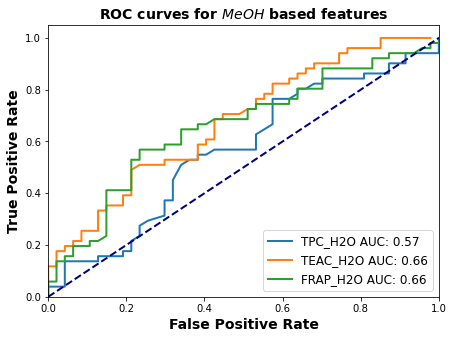

190.16
415.2957570974006

1210.5878258241385
2822.8888643695445

460.3100284286811
1474.893268952527



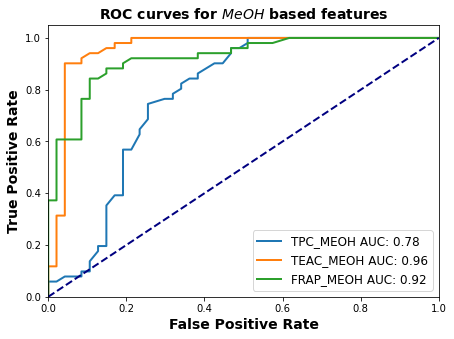

In [21]:
# ROC curves, should it be done on the entire data set, or just the training
di_h2o =[True, False, False]
draw_ROC (di_h2o, feat_H2O, y)
di_meoh =[True, True, True]
draw_ROC (di_meoh, feat_MEOH, y)

Notice the following:
 - the True positive rate = sensitivity = recall
 - false positive rate = (1-specifisity) , it tells you the proportion of the 2nd class which was not corretly classified, so the more you go to the right, the worse ?

### Statistical Baseline
it need alot of work, need to think how I am going to rewrite this

In [26]:
def measurments (data):
    cov = np.cov(data , rowvar=False)
    v1 = np.linalg.matrix_power(cov, -1)
    center = np.mean(data , axis=0)
    return cov, v1, center

def measurments1D (sample, data):
    #z scores of the points
    sd = np.std(data)
    center = np.mean(data)
    z = np.abs( (sample-center)/sd )
    return z

def nested (xtrain, ytrain, xtest, ytest, numFeat):
    xtrain = np.array(xtrain)
    ytrain = np.array(ytrain).flatten()
    xtest = np.array(xtest)
    ytest = np.array(ytest).flatten()

    
    xtrain_fer = xtrain[np.where(ytrain == 1)]
    xtrain_nf = xtrain[np.where(ytrain == 0)]
    testFer = []
    testNF = []
    
    if numFeat == 1:
        for test in xtest:
            testFer.append(measurments1D(test, xtrain_fer))
            testNF.append(measurments1D(test, xtrain_nf))
    
    else:    
        covFer, v1Fer, centerFer =  measurments(xtrain_fer)
        covNF, v1NF, centerNF =  measurments(xtrain_nf)
        
        for test in xtest:
            testFer.append(distance.mahalanobis(test, centerFer, v1Fer))
            testNF.append(distance.mahalanobis(test, centerNF, v1NF))
        
    yPred = []
    for i in range(len(xtest)):
        if testFer[i] >= testNF[i]:
            yPred.append(0)
        else:
            yPred.append(1)
                

    acc = accuracy_score(ytest, np.array(yPred))
    return acc
        
        

def jack(xtrain, ytrain, xtest, ytest, numFeat):
    accTot = nested(xtrain, ytrain, xtest, ytest, numFeat)
    
    jackTrainArr = []
    jackTestArr = []
            
    for i in range(len(xtrain)):
        x_train = np.delete(np.array(xtrain), i, 0)
        y_train = np.delete(np.array(ytrain), i, 0)
        
        scoreTrain = nested(x_train, y_train, xtest, ytest, numFeat)
        
        jackTrainArr.append(scoreTrain)
            
    for t in range (len(xtest)):
        x_test = np.delete(np.array(xtest), t, 0)
        y_test = np.delete(np.array(ytest), t, 0)
            
        scoreTest = nested(xtrain, ytrain, x_test, y_test, numFeat)
        
        jackTestArr.append(scoreTest)  
            
    return  accTot, jackTrainArr, jackTestArr




In [30]:
x_h2o = df[['TPC_H2O', 'TEAC_H2O',  'FRAP_H2O']]
y_h2o = df[['type']]

features = [['TPC_H2O']]
splits = [0.5, 0.4, 0.2]

In [31]:
file = open("thn_h2o.txt", "a")

for s in splits:
    X_train, X_test, y_train, y_test = train_test_split(x_h2o, y_h2o, test_size= s, random_state=1, stratify = y_h2o, shuffle = True)
    for f in features:
        xtr =  X_train[f]
        xte =  X_test[f]
        results = jack (xtr, y_train, xte, y_test, len(f))
        
        arg = dict()
        arg['split'] = s
        arg['model'] = 'base'
        arg['feat'] = f
        arg['totAcc'] = results[0]
        arg['jackTrain'] = results[1]
        arg['jackTest'] = results[2]
        file.write(str(arg))
        file.write("\n")
        print(arg)
        print()
file.close()   

{'split': 0.5, 'model': 'base', 'feat': ['TPC_H2O'], 'totAcc': 0.5510204081632653, 'jackTrain': [0.5510204081632653, 0.5306122448979592, 0.5306122448979592, 0.5306122448979592, 0.46938775510204084, 0.5510204081632653, 0.5510204081632653, 0.5510204081632653, 0.5510204081632653, 0.5510204081632653, 0.5102040816326531, 0.5918367346938775, 0.5714285714285714, 0.5714285714285714, 0.5510204081632653, 0.5306122448979592, 0.5510204081632653, 0.5714285714285714, 0.5510204081632653, 0.5306122448979592, 0.5510204081632653, 0.5306122448979592, 0.46938775510204084, 0.46938775510204084, 0.4897959183673469, 0.5510204081632653, 0.5714285714285714, 0.5714285714285714, 0.46938775510204084, 0.5714285714285714, 0.5510204081632653, 0.5510204081632653, 0.5306122448979592, 0.5306122448979592, 0.5714285714285714, 0.5510204081632653, 0.5306122448979592, 0.5510204081632653, 0.5510204081632653, 0.5510204081632653, 0.4897959183673469, 0.5510204081632653, 0.6122448979591837, 0.5306122448979592, 0.5510204081632653,